# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from data_loader import LungSoundDS
import torch.optim as optim
from Net import Cnn
from torch.optim.lr_scheduler import StepLR
from torchaudio import transforms
from utils import Compose, DataFromSubset, SpecPermute
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from torchsummary import summary

In [2]:
rng = np.random.RandomState(0)
torch.manual_seed(0);

# Defining Functions for Train and Test

In [3]:
# Reset Weights between folds
def reset_weights(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

In [4]:
# Calculate accuracy for each batch
def model_acc(output, target):
    output_ls = torch.log_softmax(output, dim = 1)
    _, y_pred = torch.max(output_ls, dim = 1)  
    correct = torch.eq(y_pred, target).float()
    
    acc = correct.sum().item()/len(correct)
    return acc

In [5]:
# Train the Model
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    batch_loss=0
    batch_acc=0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # Add all batch loss
        batch_loss += loss.item()*data.size(0)
        
        acc = model_acc(output, target)
    
        # Add all batch accuracy
        batch_acc += acc*target.size(0)

    # Epoch Loss and Accuracy 
    train_loss = batch_loss/len(train_loader.dataset)
    train_acc  = batch_acc/len(train_loader.dataset)
    
    return train_loss, train_acc

In [35]:
def compute_metrics(model, device, testloader, criterion, classes_names):
    with torch.no_grad():
        model.eval()

        val_loss = 0
        val_correct = 0

        score_list   = []
        pred_list    = []
        target_list  = []

        # Convert image data into single channel data
        for iter_num, (data, target) in enumerate(testloader):   
            image, target = data.to(device), target.to(device)

            output = model(image)

            # Log loss
            output = torch.log_softmax(output, dim = 1)
            loss = criterion(output, target)
            val_loss += loss.item()*data.size(0)

            # Calculate the number of correctly classified examples
            pred = output.argmax(dim=1)
            val_correct += pred.eq(target).sum().item()
            
            # Appending 
            pred_list.extend(pred.squeeze().tolist())
            target_list.extend(target.squeeze().tolist()) 
            score_list.extend(nn.Softmax(dim = 1)(output)[:,1].squeeze().tolist())

    # metrics
    F1_score = f1_score(target_list, pred_list, average="macro") 
    Accuracy = accuracy_score(target_list, pred_list)
    Precision= precision_score(target_list, pred_list, average="macro") 
    Recall   = recall_score(target_list, pred_list, average="macro")  
    #Roc_AUC  = roc_auc_score(target_list, score_list, average="macro",multi_class='ovo')
    conf_matrix= confusion_matrix(target_list, pred_list)
    
    # put together values
    metrics_dict = {"Accuracy": Accuracy,
                    "F1-score": F1_score,
                    "Precision":Precision,
                    "Recall": Recall,
                    "Loss": val_loss/len(testloader.dataset),
                    "CM":conf_matrix}
    
    return metrics_dict

In [7]:
sample_rate = 22050 
n_fft = 512
win_length = 512
hop_length = 512
n_mels = 64
n_stft=257

transfAug = Compose([transforms.Spectrogram(n_fft=n_fft,win_length=win_length,hop_length=hop_length), 
                     transforms.FrequencyMasking(freq_mask_param=10),
                     transforms.TimeMasking(time_mask_param=10),
                     transforms.MelScale(n_mels=n_mels,sample_rate=sample_rate,n_stft=257),
                     transforms.AmplitudeToDB(), 
                     SpecPermute()])

transfNoAug= Compose([transforms.Spectrogram(n_fft=n_fft,win_length=win_length,hop_length=hop_length), 
                      transforms.MelScale(n_mels=n_mels,sample_rate=sample_rate,n_stft=n_stft),
                      transforms.AmplitudeToDB(), 
                      SpecPermute()])

In [8]:
# Put on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Loading Dataset

In [9]:
path = r'sound_dataset/'
df = pd.read_csv('data.csv')
                 
dataset = LungSoundDS(df, path)
print('Number of samples:',len(dataset))

Number of samples: 19370


# Defining Model and Params

In [10]:
classes_num = 4
# 0: Normal Samples | 1: Crackles | 2: Wheezes | 3: Wheezes and Crackles
classes_names = ['Normal','Crackles','Wheezes','W_C']

model = Cnn(classes_num)
model = model.to(device)

In [11]:
#summary(model, (1,64,64))

In [12]:
learning_rate = 1e-4

# passing only those parameters that explicitly requires grad
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, eps=1e-08, weight_decay=0, amsgrad=True)

criterion = nn.CrossEntropyLoss()

In [13]:
batch_size=16
epochs=200

# Training

## Using Hold out cross validation

In [14]:
targets = dataset.df.id.values

In [15]:
train_idx, valid_idx = train_test_split(np.arange(len(targets)),test_size=0.4,
                                       shuffle=True,stratify=targets, random_state=42)

In [1]:
test_idx, val_idx = train_test_split(valid_idx,test_size=0.5,
                                     shuffle=True,stratify=targets[valid_idx], random_state=42)

NameError: name 'train_test_split' is not defined

In [17]:
train_subset = Subset(dataset, train_idx)
val_subset   = Subset(dataset, val_idx)
test_subset  = Subset(dataset, test_idx)

In [18]:
# Applying Transformations (spectrogram, melspectrogram and data augmentation)
train_dataset = DataFromSubset(train_subset, transform=transfNoAug)
val_dataset   = DataFromSubset(val_subset, transform=transfNoAug)
test_dataset  = DataFromSubset(test_subset, transform=transfNoAug)


# Generate Dataloader to Feed the Model
trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valLoader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testLoader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Train

In [19]:
# creating dictionary for statistics

## Train Set Dictionary 
train_stats = {"acc": [], "loss": []}
val_stats = {"acc": [], "loss": []}

## Test Set Metrics by Folder
kfolder_stats = {"Accuracy": [],
                "F1-score": [],
                "Precision":[],
                "Recall": [],
                "Test_Loss": []}

## Storage Mean and Std Results 
average = {"Accuracy": [],
           "F1-score": [],
           "Precision":[],
           "Recall": [],
           "Test_Loss": []}

In [20]:
## Dictionary for epoch Statistics
epoch_train = {"acc": [], "loss": []}
epoch_val = {"acc": [], "loss": []}
best_val_score = 0

# Epoch Loop for Training and Evaluation
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, device, trainLoader, optimizer, criterion)

    metrics = compute_metrics(model, device, valLoader, criterion, classes_names)

    # Statistics
    train_stats["acc"].append(train_acc)
    train_stats["loss"].append(train_loss)

    val_stats["acc"].append(metrics["Accuracy"])
    val_stats["loss"].append(metrics["Loss"])

    # Saving best Model
    if metrics["Accuracy"]>best_val_score:
        torch.save(model.state_dict(), "best_model.pth")
        best_val_score = metrics['Accuracy']
        
    
    # Print Metris
    print(f'Epoch {epoch} --> Train Metrics: Accuracy: {train_acc:.2f} -- Loss: {train_loss:.2f} | Validation Metrics: Accuracy: {metrics["Accuracy"]:.2f} ---- Loss: {metrics["Loss"]:.2f}')

print('finish training')

Epoch 1 --> Train Metrics: Accuracy: 0.47 -- Loss: 1.20 | Validation Metrics: Accuracy: 0.50 ---- Loss: 1.11
Epoch 2 --> Train Metrics: Accuracy: 0.53 -- Loss: 1.07 | Validation Metrics: Accuracy: 0.55 ---- Loss: 1.03
Epoch 3 --> Train Metrics: Accuracy: 0.57 -- Loss: 1.01 | Validation Metrics: Accuracy: 0.55 ---- Loss: 1.03
Epoch 4 --> Train Metrics: Accuracy: 0.59 -- Loss: 0.96 | Validation Metrics: Accuracy: 0.56 ---- Loss: 0.99
Epoch 5 --> Train Metrics: Accuracy: 0.61 -- Loss: 0.92 | Validation Metrics: Accuracy: 0.57 ---- Loss: 0.98
Epoch 6 --> Train Metrics: Accuracy: 0.62 -- Loss: 0.89 | Validation Metrics: Accuracy: 0.59 ---- Loss: 0.96
Epoch 7 --> Train Metrics: Accuracy: 0.65 -- Loss: 0.85 | Validation Metrics: Accuracy: 0.58 ---- Loss: 0.96
Epoch 8 --> Train Metrics: Accuracy: 0.66 -- Loss: 0.82 | Validation Metrics: Accuracy: 0.60 ---- Loss: 0.93
Epoch 9 --> Train Metrics: Accuracy: 0.67 -- Loss: 0.79 | Validation Metrics: Accuracy: 0.59 ---- Loss: 0.94
Epoch 10 --> Train 

Epoch 76 --> Train Metrics: Accuracy: 0.97 -- Loss: 0.08 | Validation Metrics: Accuracy: 0.71 ---- Loss: 1.69
Epoch 77 --> Train Metrics: Accuracy: 0.97 -- Loss: 0.08 | Validation Metrics: Accuracy: 0.69 ---- Loss: 1.69
Epoch 78 --> Train Metrics: Accuracy: 0.97 -- Loss: 0.08 | Validation Metrics: Accuracy: 0.70 ---- Loss: 1.74
Epoch 79 --> Train Metrics: Accuracy: 0.97 -- Loss: 0.07 | Validation Metrics: Accuracy: 0.71 ---- Loss: 1.71
Epoch 80 --> Train Metrics: Accuracy: 0.97 -- Loss: 0.07 | Validation Metrics: Accuracy: 0.70 ---- Loss: 1.85
Epoch 81 --> Train Metrics: Accuracy: 0.97 -- Loss: 0.08 | Validation Metrics: Accuracy: 0.70 ---- Loss: 1.76
Epoch 82 --> Train Metrics: Accuracy: 0.97 -- Loss: 0.08 | Validation Metrics: Accuracy: 0.70 ---- Loss: 1.74
Epoch 83 --> Train Metrics: Accuracy: 0.98 -- Loss: 0.07 | Validation Metrics: Accuracy: 0.70 ---- Loss: 1.76
Epoch 84 --> Train Metrics: Accuracy: 0.98 -- Loss: 0.06 | Validation Metrics: Accuracy: 0.71 ---- Loss: 1.72
Epoch 85 -

Epoch 151 --> Train Metrics: Accuracy: 0.99 -- Loss: 0.02 | Validation Metrics: Accuracy: 0.72 ---- Loss: 2.09
Epoch 152 --> Train Metrics: Accuracy: 0.99 -- Loss: 0.02 | Validation Metrics: Accuracy: 0.72 ---- Loss: 2.19
Epoch 153 --> Train Metrics: Accuracy: 0.99 -- Loss: 0.02 | Validation Metrics: Accuracy: 0.72 ---- Loss: 2.10
Epoch 154 --> Train Metrics: Accuracy: 0.99 -- Loss: 0.02 | Validation Metrics: Accuracy: 0.72 ---- Loss: 2.12
Epoch 155 --> Train Metrics: Accuracy: 0.99 -- Loss: 0.02 | Validation Metrics: Accuracy: 0.72 ---- Loss: 2.22
Epoch 156 --> Train Metrics: Accuracy: 0.99 -- Loss: 0.02 | Validation Metrics: Accuracy: 0.72 ---- Loss: 2.28
Epoch 157 --> Train Metrics: Accuracy: 0.99 -- Loss: 0.02 | Validation Metrics: Accuracy: 0.72 ---- Loss: 2.13
Epoch 158 --> Train Metrics: Accuracy: 0.99 -- Loss: 0.02 | Validation Metrics: Accuracy: 0.72 ---- Loss: 2.12
Epoch 159 --> Train Metrics: Accuracy: 0.99 -- Loss: 0.02 | Validation Metrics: Accuracy: 0.72 ---- Loss: 2.19
E

# Statistics

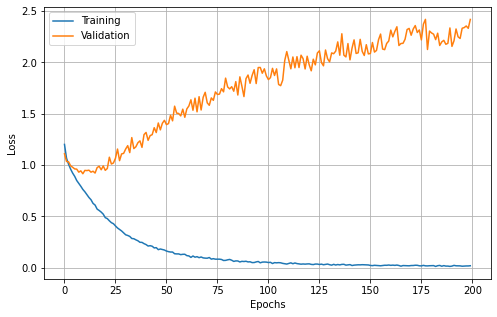

In [24]:
# Loss Figure plotting and saving figure
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5)) 
plt.grid() 
plt.plot(train_stats['loss'])
plt.plot(val_stats['loss'])
plt.legend(['Training','Validation'])
plt.ylabel('Loss'), plt.xlabel('Epochs')
plt.savefig('loss_curve.pdf'), plt.show();

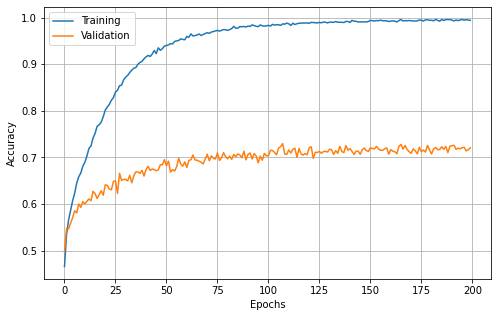

In [26]:
# Accuracy plotting and saving figure
plt.figure(figsize=(8,5)) 
plt.grid() 
plt.plot(train_stats['acc'])
plt.plot(val_stats['acc'])
plt.legend(['Training','Validation'])
plt.ylabel('Accuracy'), plt.xlabel('Epochs')
plt.savefig('acc_curve.pdf', dpi=200), plt.show();

## Loading Model

In [27]:
#loading 
    model = Cnn(classes_num)
    model.load_state_dict(torch.load('best_model.pth', map_location=device)) 
    model.to(device);

Cnn(
  (conv_block1): ConvBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block3): ConvBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [36]:
test_metrics = compute_metrics(model, device, testLoader, criterion, classes_names)

In [64]:
print('Results for Test Set \n')
print(f"Accuracy: {test_metrics['Accuracy']:.2f}")
print(f"F1 Score: {test_metrics['F1-score']:.2f}")
print(f"Precision: {test_metrics['Precision']:.2f}")
print(f"Recall: {test_metrics['Recall']:.2f}")
print(f"Loss: {test_metrics['Loss']:.2f}")

Results for Test Set 

Accuracy: 0.70
F1 Score: 0.69
Precision: 0.69
Recall: 0.68
Loss: 1.99


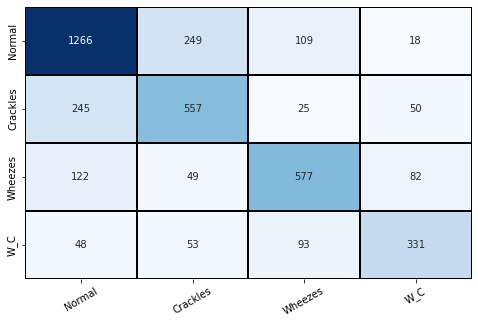

In [52]:
import seaborn as sn

plt.figure(figsize = (8,5))
sn.heatmap(test_metrics['CM'], annot=True, fmt=".0f", cmap ='Blues',xticklabels=classes_names, yticklabels=classes_names,
           linecolor='k', linewidths=.3, cbar=False)
plt.xticks(rotation=30)
plt.savefig('confusion.pdf', dpi=200), plt.show();